In [ ]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Classical models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Neural network (Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

from itertools import product

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Dataset

## Load Dataset

In [2]:
data_path = 'data/data_3dcp_clean.csv'
data = pd.read_csv(data_path)

print(data.head())
print("\nData summary:")
print(data.describe())

   speed  extrusion  layer_height  layer_width
0     80          5             5        52.05
1     80          5             5        50.50
2     80          5             5        57.78
3    100          5             5        57.16
4    100          5             5        48.00

Data summary:
            speed  extrusion  layer_height  layer_width
count  318.000000  318.00000    318.000000   318.000000
mean   172.327044    7.50000      9.339623    39.935849
std     96.756190    2.50394      3.566104    24.910630
min     20.000000    5.00000      5.000000    13.390000
25%    100.000000    5.00000      5.000000    22.717500
50%    160.000000    7.50000      8.000000    32.370000
75%    240.000000   10.00000     12.000000    48.007500
max    360.000000   10.00000     15.000000   142.500000


## Train-Test Split

In [3]:
# Define features and target
X = data[['extrusion', 'layer_height', 'layer_width']]
y = data['speed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (254, 3)
Test set shape: (64, 3)


# Neural Network Model

## ANN Model

In [4]:
def create_nn_model(input_dim, model_depth=2,layer_size=32, l1_rate=1e-3, l2_rate=1e-3, dropout_rate=0.0, learning_rate=1e-2):
    model = Sequential()

    model.add(Input((input_dim,)))

    for _ in range(model_depth):
        model.add(Dense(layer_size, activation='elu',
                        kernel_regularizer=l1_l2(l1_rate, l2_rate)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

## K-fold Cros-Validation

In [ ]:
# Set up KFold cross-validation for the NN
kf = KFold(n_splits=5, shuffle=True, random_state=42)
nn_cv_metrics = []
fold = 1

for train_index, val_index in kf.split(X_train):
    # Split the training set into fold-specific training and validation sets
    X_tr_fold = X_train.iloc[train_index]
    X_val_fold = X_train.iloc[val_index]
    y_tr_fold = y_train.iloc[train_index]
    y_val_fold = y_train.iloc[val_index]
    
    scaler_nn = RobustScaler()
    X_tr_fold_scaled = scaler_nn.fit_transform(X_tr_fold)
    X_val_fold_scaled = scaler_nn.transform(X_val_fold)
    
    # Build and train the NN model
    model_nn = create_nn_model(input_dim=X_tr_fold_scaled.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose=0)
    
    history = model_nn.fit(X_tr_fold_scaled, y_tr_fold, epochs=250, batch_size=32, verbose=0,
                           validation_data=(X_val_fold_scaled, y_val_fold), callbacks=[reduce_lr, early_stopping])
    
    # Evaluate the model on the validation fold
    y_val_pred = model_nn.predict(X_val_fold_scaled, verbose=0)
    
    mse_fold = mean_squared_error(y_val_fold, y_val_pred)
    mae_fold = mean_absolute_error(y_val_fold, y_val_pred)
    rmse_fold = np.sqrt(mse_fold)
    r2_fold = r2_score(y_val_fold, y_val_pred)
    
    # Store metrics for this fold
    fold_metrics = {'mse': mse_fold, 'mae': mae_fold, 'rmse': rmse_fold, 'r2': r2_fold}
    nn_cv_metrics.append(fold_metrics)
    
    # Print metrics for this fold
    print(f"Fold {fold} Neural Network Validation Metrics:")
    print(f"  MSE:  {mse_fold:.3f}, MAE:  {mae_fold:.3f}, RMSE: {rmse_fold:.3f}, R2:   {r2_fold:.3f}")
    print("---------------------")
    fold += 1

# Compute average metrics across folds
avg_mse = np.mean([m['mse'] for m in nn_cv_metrics])
avg_mae = np.mean([m['mae'] for m in nn_cv_metrics])
avg_rmse = np.mean([m['rmse'] for m in nn_cv_metrics])
avg_r2 = np.mean([m['r2'] for m in nn_cv_metrics])

print("\nAverage Neural Network Validation Metrics (5-Fold CV):")
print(f"    MSE: {avg_mse:.3f}, MAE: {avg_mae:.3f}, RMSE: {avg_rmse:.3f}, R2: {avg_r2:.3f}")

Fold 1 Neural Network Validation Metrics:
  MSE:  192.942, MAE:  10.769, RMSE: 13.890, R2:   0.981
---------------------
Fold 2 Neural Network Validation Metrics:
  MSE:  626.925, MAE:  14.731, RMSE: 25.038, R2:   0.946
---------------------
Fold 3 Neural Network Validation Metrics:
  MSE:  789.298, MAE:  17.826, RMSE: 28.094, R2:   0.883
---------------------
Fold 4 Neural Network Validation Metrics:
  MSE:  153.789, MAE:  9.923, RMSE: 12.401, R2:   0.983
---------------------
Fold 5 Neural Network Validation Metrics:
  MSE:  837.838, MAE:  25.038, RMSE: 28.945, R2:   0.890
---------------------

Average Neural Network Validation Metrics (5-Fold CV):
    MSE: 520.159, MAE: 15.657, RMSE: 21.674, R2: 0.937


## Train Model

In [6]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

nn = create_nn_model(input_dim=X_train_scaled.shape[1])
early_stopping = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=1e-5, verbose=0)

history = nn.fit(X_train_scaled, y_train, epochs=1000, batch_size=32, verbose=2,
                             validation_split=0.0, callbacks=[reduce_lr, early_stopping])

Epoch 1/1000
8/8 - 1s - 75ms/step - loss: 36779.2344 - learning_rate: 0.0100
Epoch 2/1000
8/8 - 0s - 9ms/step - loss: 35476.1953 - learning_rate: 0.0100
Epoch 3/1000
8/8 - 0s - 9ms/step - loss: 32670.8066 - learning_rate: 0.0100
Epoch 4/1000
8/8 - 0s - 9ms/step - loss: 27451.9277 - learning_rate: 0.0100
Epoch 5/1000
8/8 - 0s - 9ms/step - loss: 19914.8672 - learning_rate: 0.0100
Epoch 6/1000
8/8 - 0s - 9ms/step - loss: 11625.5947 - learning_rate: 0.0100
Epoch 7/1000
8/8 - 0s - 9ms/step - loss: 5562.9751 - learning_rate: 0.0100
Epoch 8/1000
8/8 - 0s - 10ms/step - loss: 3398.5498 - learning_rate: 0.0100
Epoch 9/1000
8/8 - 0s - 9ms/step - loss: 2189.8232 - learning_rate: 0.0100
Epoch 10/1000
8/8 - 0s - 9ms/step - loss: 1469.4446 - learning_rate: 0.0100
Epoch 11/1000
8/8 - 0s - 9ms/step - loss: 1433.7457 - learning_rate: 0.0100
Epoch 12/1000
8/8 - 0s - 9ms/step - loss: 1321.2050 - learning_rate: 0.0100
Epoch 13/1000
8/8 - 0s - 9ms/step - loss: 1283.0238 - learning_rate: 0.0100
Epoch 14/1000

## Save/Load Model and Scaler (Optional)

In [15]:
SAVE_MODEL = True
LOAD_MODEL = False

SAVE_DIR = 'model'
FILE_NAME = '3DCP_ANN'

In [16]:
if SAVE_MODEL:
    os.makedirs(SAVE_DIR, exist_ok=True)

    # Save the complete Keras model in .keras format (this includes weights, architecture, and optimizer state)
    nn.save(f"{SAVE_DIR}/{FILE_NAME}_model.keras")

    # Save the scaler using joblib
    joblib.dump(scaler, f"{SAVE_DIR}/{FILE_NAME}_scaler.pkl")

    print("Model and Scaler saved successfully!")
else:
    print("Skipped saving Model and Scaler.")

Model and Scaler saved successfully!


In [9]:
if LOAD_MODEL:
    nn = load_model(f"{SAVE_DIR}/{FILE_NAME}_model.keras")
    scaler = joblib.load(f"{SAVE_DIR}/{FILE_NAME}_scaler.pkl")

    print("Model and Scaler loaded successfully!")
else:
    print("Skipped loading Model and Scaler.")

Skipped loading Model and Scaler.


## Plot Residiuals (Predicted-Observed)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Final Neural Network Test Set Performance:
R²: 0.9626, MSE: 362.9162, RMSE: 19.0504, MAE: 12.9281, 


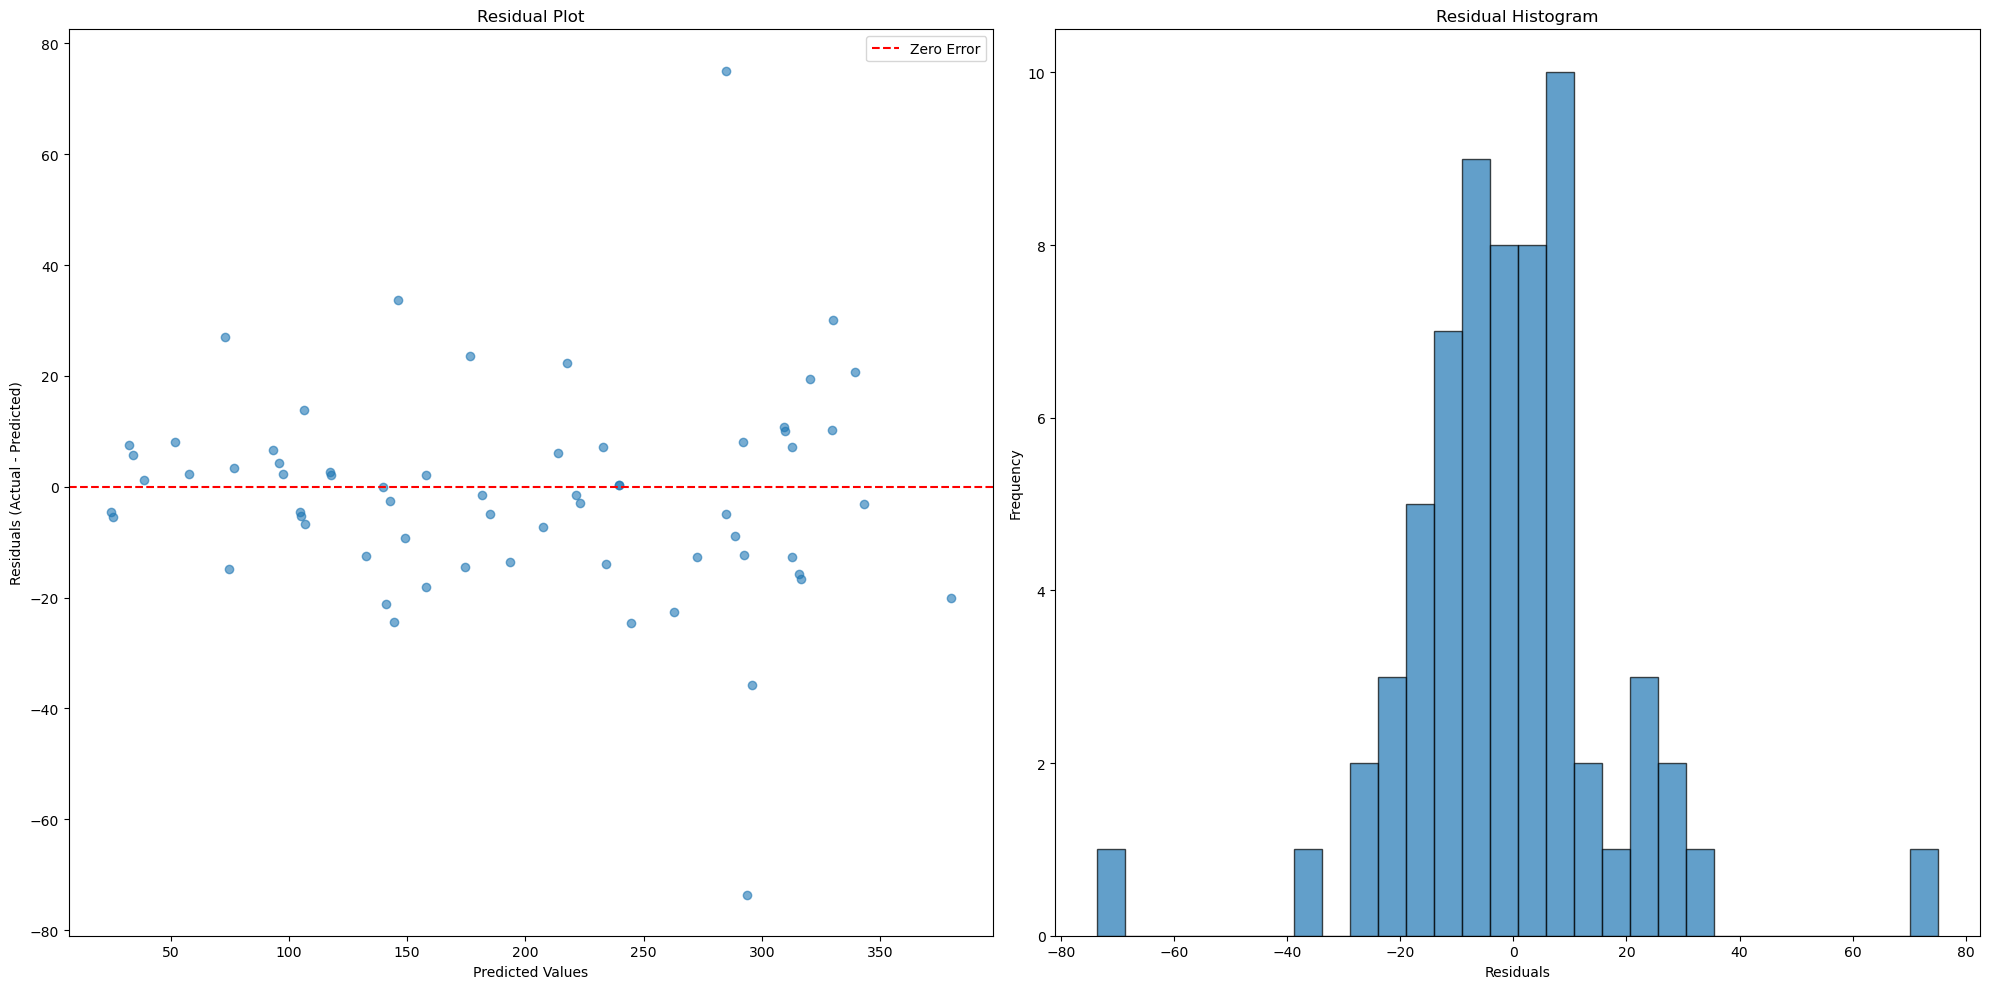

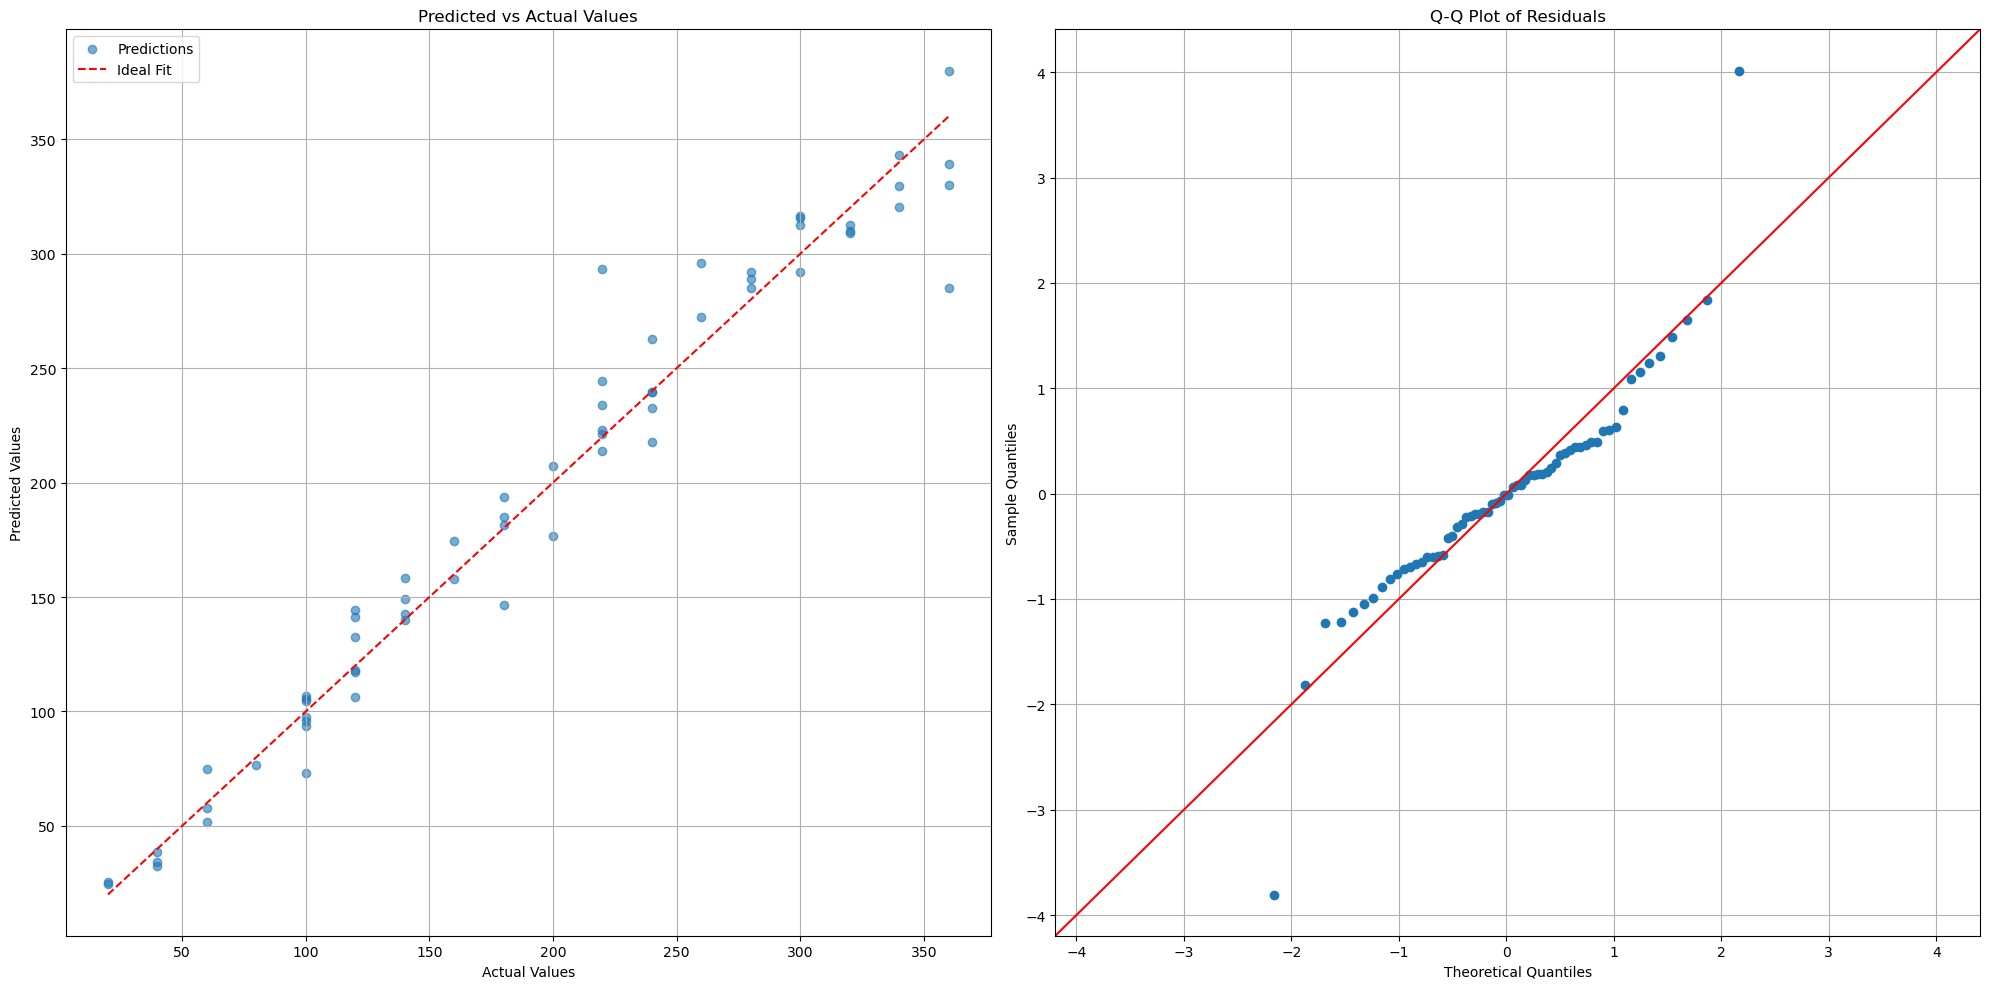

In [10]:
# Evaluate on the test set
y_test_pred = nn.predict(X_test_scaled)
r2  = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = root_mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)

print("\nFinal Neural Network Test Set Performance:")
print(f"R²: {r2:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, ")

# Compute residuals: ensure y_test_pred is a 1D array
residuals = y_test - y_test_pred.flatten()

plt.figure(figsize=(20, 10))

# Residual scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label="Zero Error")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.legend()

# Residual histogram
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Histogram")

plt.tight_layout()
plt.show()

import statsmodels.api as sm

# Ensure y_test_pred is 1D
y_pred = y_test_pred.flatten()

# Compute residuals
residuals = y_test - y_pred

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# 1. Predicted vs Actual (Parity) Plot on the first subplot
axs[0].scatter(y_test, y_pred, alpha=0.6, label="Predictions")
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal Fit")
axs[0].set_xlabel("Actual Values")
axs[0].set_ylabel("Predicted Values")
axs[0].set_title("Predicted vs Actual Values")
axs[0].legend()
axs[0].grid(True)

# 2. Q-Q Plot of the residuals on the second subplot
sm.qqplot(residuals, line='45', fit=True, ax=axs[1])
axs[1].set_title("Q-Q Plot of Residuals")
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [11]:
# Define the search grid ranges
layer_height_range = [5, 8, 10, 12, 15, 18]
layer_width_range  = np.linspace(15, 50, num=6)
extrusion_values   = [5, 10]

# Create the Cartesian product
grid = list(product(extrusion_values, layer_height_range, layer_width_range))
search_grid = pd.DataFrame(grid, columns=['extrusion', 'layer_height', 'layer_width'])

# Scale the grid data using the final scaler
search_grid_scaled = scaler.transform(search_grid)

# Predict speed with the final NN model
grid_predictions = nn.predict(search_grid_scaled)
search_grid['speed'] = np.round(grid_predictions).astype(int)

display(search_grid)

if SAVE_MODEL:
    search_grid.to_csv(f"{SAVE_DIR}/{FILE_NAME}_validation.csv", index=False)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


,extrusion,layer_height,layer_width,speed
0,5,5,15.0,428
1,5,5,22.0,301
2,5,5,29.0,206
3,5,5,36.0,149
4,5,5,43.0,114
...,...,...,...,...
67,10,18,22.0,148
68,10,18,29.0,112
69,10,18,36.0,91
70,10,18,43.0,74


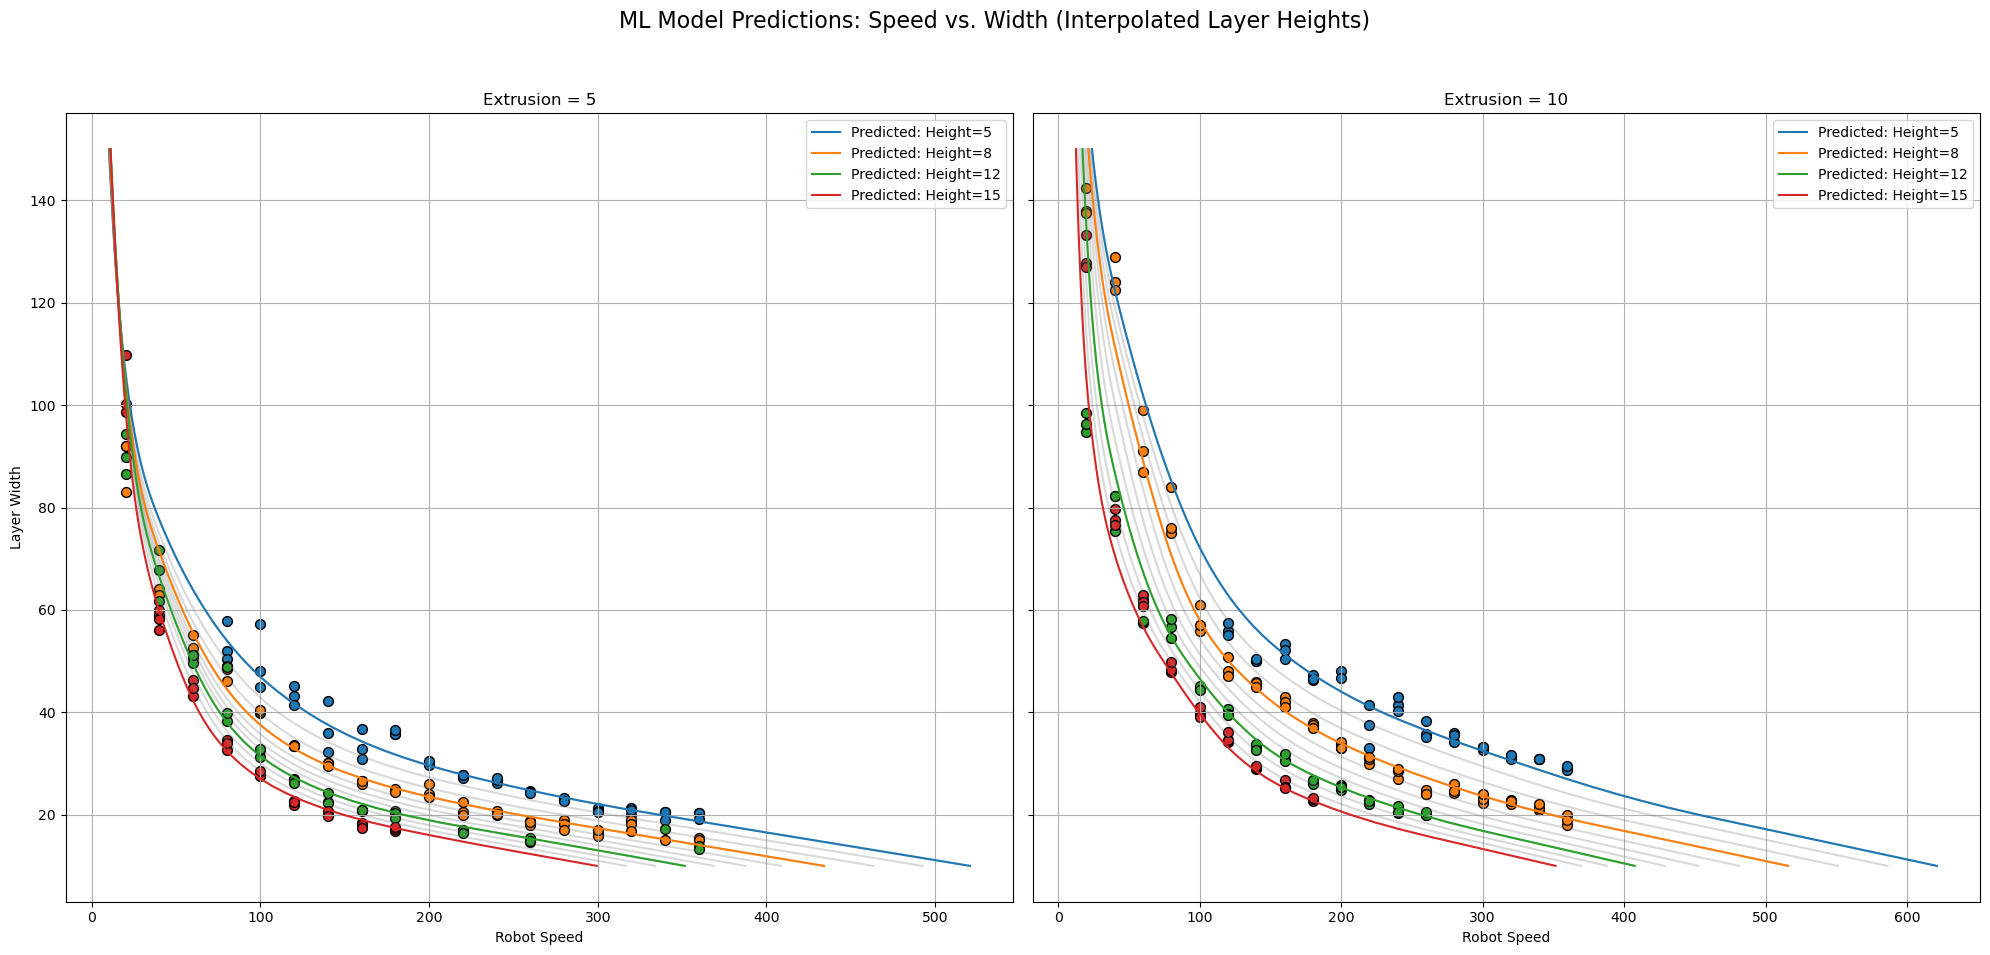

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_speed_vs_width_interpolation(
    nn_model,
    scaler,
    main_heights=[5, 8, 12, 15],
    extrusions=[5, 10],
    w_min=10,
    w_max=150,
    w_points=100,
    data_points=None  # Optional: DataFrame with actual data
):
    """
    For each extrusion value, this function:
      1. Draws faint gray prediction curves for every integer layer height from 5 to 20.
      2. Draws colored prediction curves for the 'main_heights' list.
      3. Optionally overlays actual data points if a DataFrame is provided.
    """
    # Generate a range of widths
    widths = np.linspace(w_min, w_max, w_points)

    # Create subplots: one subplot per extrusion value
    n_extrusions = len(extrusions)
    fig_h = 10
    fig, axes = plt.subplots(1, n_extrusions, figsize=(fig_h * n_extrusions, fig_h), sharey=True)
    if n_extrusions == 1:
        axes = [axes]

    # Define all heights from 5 to 20 (inclusive)
    all_heights = range(5, 15)

    for ax, e in zip(axes, extrusions):
        # -----------------------------
        # 1. Plot faint gray lines for every integer height in [5..20]
        # -----------------------------
        for h in all_heights:
            # Build the input array: columns = [layer_height, layer_width, extrusion]
            X = np.column_stack([
                np.full_like(widths, h),
                widths,
                np.full_like(widths, e)
            ])
            # Convert to DataFrame in the order the scaler expects
            X_df = pd.DataFrame(X, columns=["layer_height", "layer_width", "extrusion"])
            X_df = X_df[scaler.feature_names_in_]
            
            # Scale the inputs and predict speed
            X_scaled = scaler.transform(X_df)
            predicted_speed = nn_model.predict(X_scaled, verbose=0).flatten()

            # Plot in gray (alpha < 1 for faded effect)
            ax.plot(predicted_speed, widths, color='gray', alpha=0.3)

        # -----------------------------
        # 2. Plot main heights in color
        # -----------------------------
        for i, h in enumerate(main_heights):
            color = f"C{i}"
            X = np.column_stack([
                np.full_like(widths, h),
                widths,
                np.full_like(widths, e)
            ])
            X_df = pd.DataFrame(X, columns=["layer_height", "layer_width", "extrusion"])
            X_df = X_df[scaler.feature_names_in_]
            
            X_scaled = scaler.transform(X_df)
            predicted_speed = nn_model.predict(X_scaled, verbose=0).flatten()

            # Plot in color
            ax.plot(predicted_speed, widths, label=f"Predicted: Height={h}", color=color)

            # -----------------------------
            # 3. Overlay actual data points (optional)
            # -----------------------------
            if data_points is not None:
                subset = data_points[
                    (data_points["extrusion"] == e) & (data_points["layer_height"] == h)
                ]
                if not subset.empty:
                    ax.scatter(
                        subset["speed"], 
                        subset["layer_width"],
                        color=color, marker='o', edgecolor='black', s=50
                    )

        ax.set_xlabel("Robot Speed")
        ax.set_title(f"Extrusion = {e}")
        ax.grid(True)
        ax.legend()

    axes[0].set_ylabel("Layer Width")
    fig.suptitle("ML Model Predictions: Speed vs. Width (Interpolated Layer Heights)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Example usage:
plot_speed_vs_width_interpolation(
    nn_model=nn,
    scaler=scaler,
    main_heights=[5, 8, 12, 15],
    extrusions=[5, 10],
    w_min=10,
    w_max=150,
    w_points=100,
    data_points=data
)

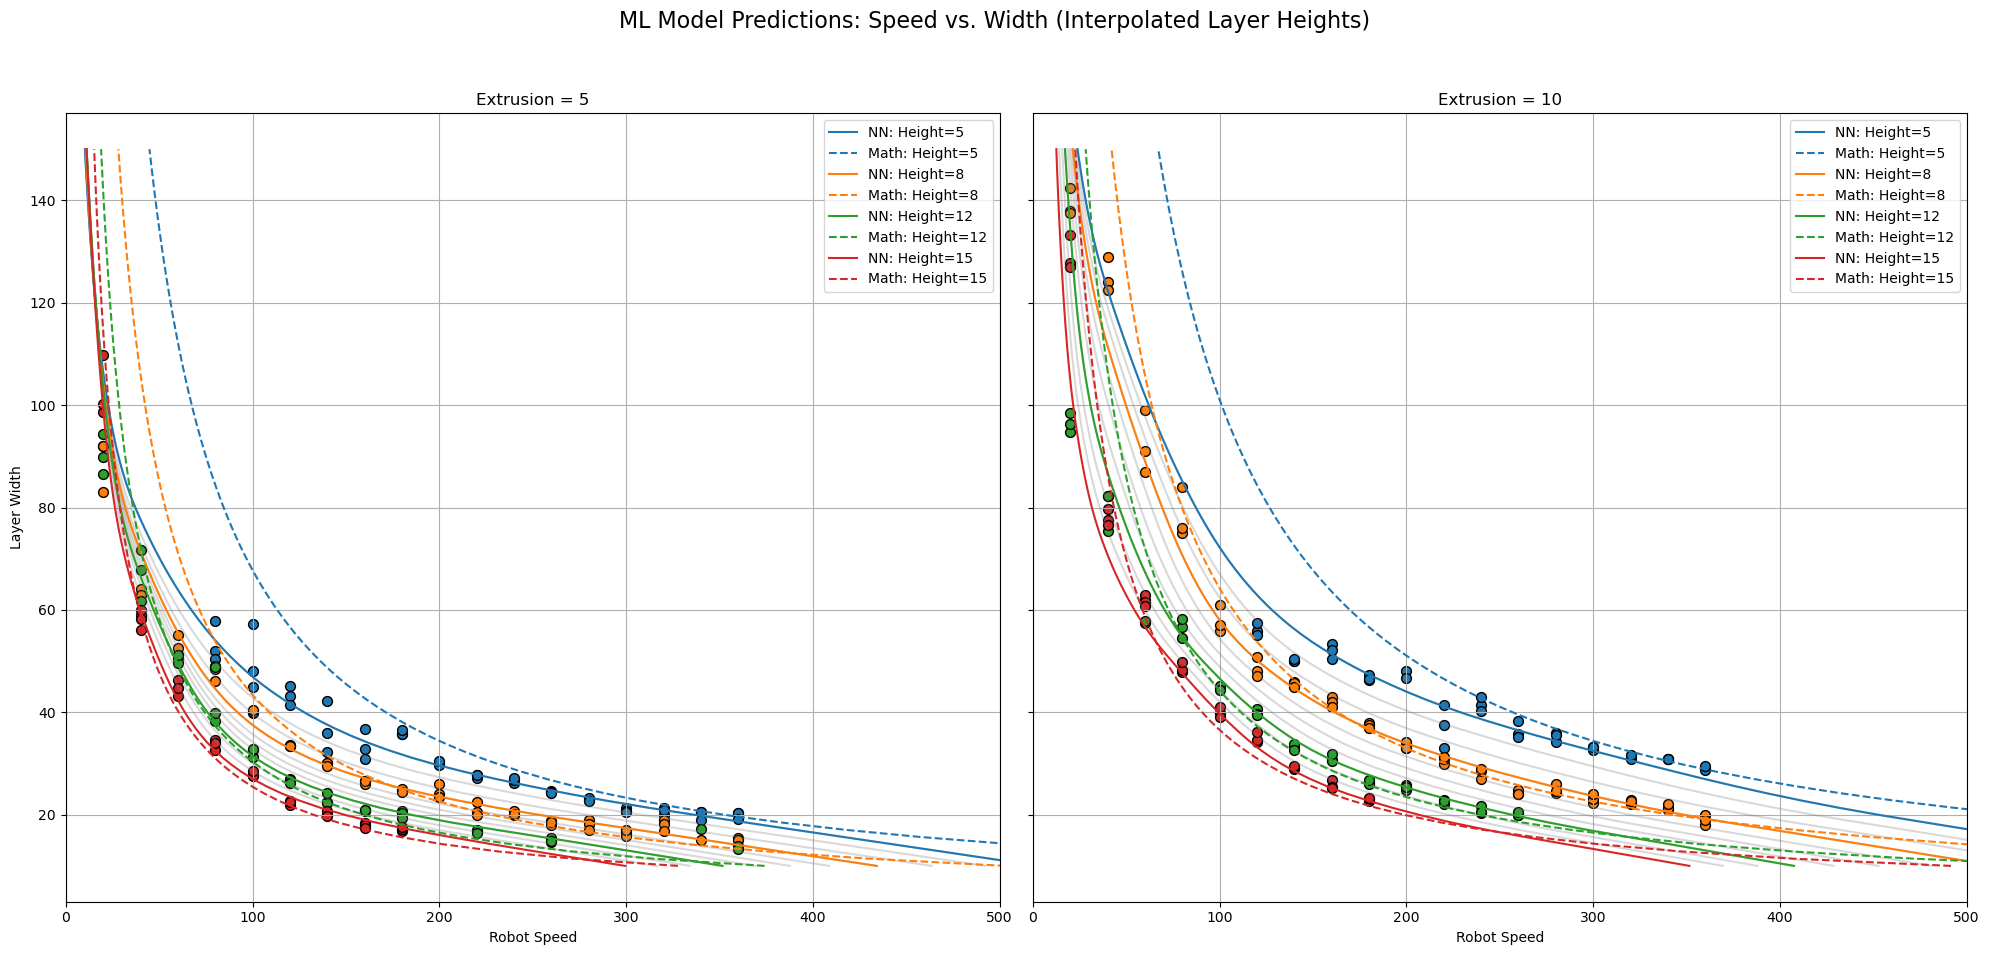

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

def plot_speed_vs_width_interpolation(
    nn_model,
    scaler,
    flowrates,
    main_heights=[5, 8, 12, 15],
    extrusions=[5, 10],
    w_min=10,
    w_max=150,
    w_points=100,
    data_points=None  # Optional: DataFrame with actual data
):
    """
    For each extrusion value, this function:
      1. Draws faint gray prediction curves for every integer layer height from 5 to 14.
      2. Draws colored prediction curves for the specified 'main_heights'.
      3. Overlays a mathematical model prediction using:
             speed = (flowrate*1e6) / (60 * ((w * h) - h**2 + ((h**2)*pi/4)))
         where flowrate is provided in the `flowrates` list (corresponding to each extrusion).
      4. Optionally overlays actual data points if a DataFrame is provided.
    """
    # Generate a range of widths
    widths = np.linspace(w_min, w_max, w_points)

    # Create subplots: one subplot per extrusion value
    n_extrusions = len(extrusions)
    fig_h = 10
    fig, axes = plt.subplots(1, n_extrusions, figsize=(fig_h * n_extrusions, fig_h), sharey=True)
    if n_extrusions == 1:
        axes = [axes]

    # Define all layer heights for the gray curves (5 to 14 inclusive)
    all_heights = range(5, 15)

    for ax, e, f in zip(axes, extrusions, flowrates):
        # -----------------------------
        # 1. Plot faint gray lines for every integer height in [5..14]
        # -----------------------------
        for h in all_heights:
            # Build the input array: columns = [layer_height, layer_width, extrusion]
            X = np.column_stack([
                np.full_like(widths, h),
                widths,
                np.full_like(widths, e)
            ])
            # Convert to DataFrame in the order the scaler expects
            X_df = pd.DataFrame(X, columns=["layer_height", "layer_width", "extrusion"])
            X_df = X_df[scaler.feature_names_in_]
            
            # Scale the inputs and predict speed
            X_scaled = scaler.transform(X_df)
            predicted_speed = nn_model.predict(X_scaled, verbose=0).flatten()

            # Plot in gray for a faded background effect
            ax.plot(predicted_speed, widths, color='gray', alpha=0.3)

        # -----------------------------
        # 2. Plot main heights in color and overlay math model predictions
        # -----------------------------
        for i, h in enumerate(main_heights):
            color = f"C{i}"
            # Neural network predictions
            X = np.column_stack([
                np.full_like(widths, h),
                widths,
                np.full_like(widths, e)
            ])
            X_df = pd.DataFrame(X, columns=["layer_height", "layer_width", "extrusion"])
            X_df = X_df[scaler.feature_names_in_]
            
            X_scaled = scaler.transform(X_df)
            predicted_speed = nn_model.predict(X_scaled, verbose=0).flatten()

            # Plot NN predictions in color
            ax.plot(predicted_speed, widths, label=f"NN: Height={h}", color=color)

            # Overlay actual data points if provided
            if data_points is not None:
                subset = data_points[
                    (data_points["extrusion"] == e) & (data_points["layer_height"] == h)
                ]
                if not subset.empty:
                    ax.scatter(
                        subset["speed"], 
                        subset["layer_width"],
                        color=color, marker='o', edgecolor='black', s=50
                    )
            
            # -----------------------------
            # 3. Overlay mathematical model predictions (using flowrate from the flowrates list)
            # -----------------------------
            # Compute speeds for each width value using the math model:
            math_speeds = ((f) * 1e6) / (60 * ((widths * h) - (h**2) + ((h**2) * np.pi / 4)))
            ax.plot(math_speeds, widths, linestyle='--', color=color, label=f"Math: Height={h}")

        ax.set_xlabel("Robot Speed")
        ax.set_title(f"Extrusion = {e}")
        ax.set_xlim(0, 500)  # Limit the x-axis to display speeds between 0 and 500
        ax.grid(True)
        ax.legend()

    axes[0].set_ylabel("Layer Width")
    fig.suptitle("ML Model Predictions: Speed vs. Width (Interpolated Layer Heights)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Example usage:
plot_speed_vs_width_interpolation(
    nn_model=nn,
    scaler=scaler,
    flowrates=[2, 3],
    main_heights=[5, 8, 12, 15],
    extrusions=[5, 10],
    w_min=10,
    w_max=150,
    w_points=100,
    data_points=data  # Replace 'data' with your actual DataFrame variable if available
)

In [14]:
# speeds = [(flowrate*10**6)/(60*((w*h)-(h**2)+((((h**2)*math.pi)/4)))) for w, h in zip(des_width, des_height)]